# 5 Pair correlation and nearest neighbors

First, let us display the pair correlation function $g(r)$ for each of the states.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

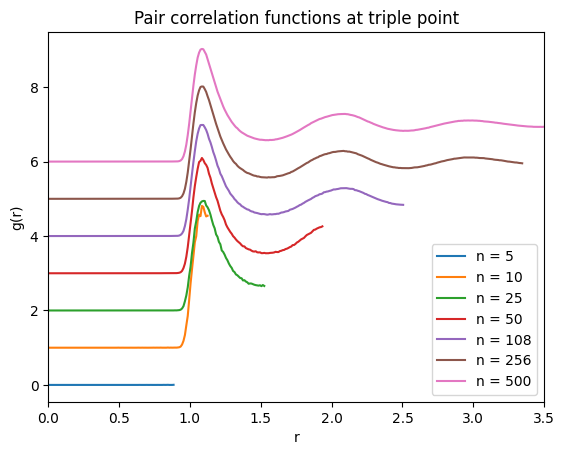

In [3]:
particleNumber = [5,10,25,50,108,256,500]
offset = 1 # offset by which each correlation function is offset to see it better


for i, m in enumerate(particleNumber):
    r,g = np.loadtxt(f'n{m}/amclj.dat', unpack = True)
    plt.plot(r,g+offset*i, label = f"n = {m}")

plt.title("Pair correlation functions at triple point")
plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()
plt.xlim([0,3.5])
plt.show()

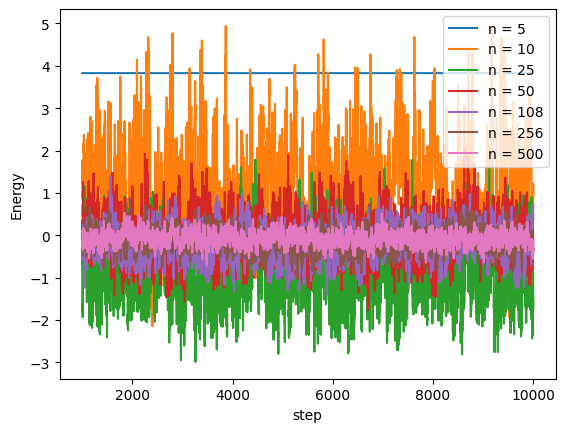

In [4]:
starting_step = 1000

for i, m in enumerate(particleNumber):
    step, acceptance, energy, pressure = np.loadtxt(f"n{m}/data.dat", unpack = True)
    plt.plot(step[starting_step:], pressure[starting_step:], label = f"n = {m}")

plt.legend()
plt.xlabel("step")
plt.ylabel("Energy")
plt.show()

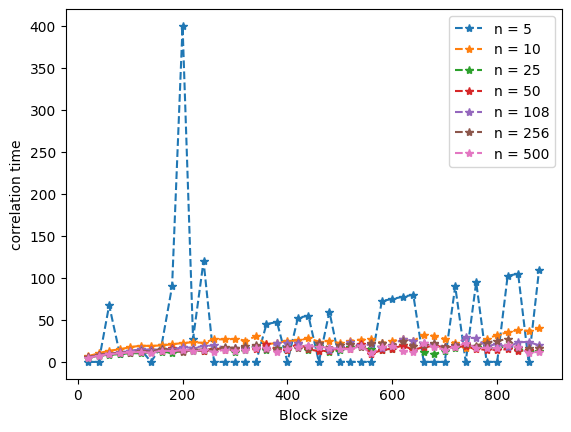

In [5]:
def calculate_correlation_time(variable):
    n = len(variable)

    m = np.arange(20,n//10,20)

    correlation_time = np.zeros(m.shape)
    var = np.var(variable)

    for j, mm in enumerate(m):
        
        # Trim the variable so you can do calculations
        length = n - n % mm
        variable_ = variable.copy()[:length]
        #print(len(variable)-mm)

        Am = np.reshape(variable_, (-1,mm))
        Am_average = Am.mean(axis=1)
        correlation_time[j] = np.var(Am_average)*mm/var/2
    return m, correlation_time

plotOffset = 0


for i, m in enumerate(particleNumber):
    step, acceptance, energy, pressure = np.loadtxt(f"n{m}/data.dat", unpack = True)

    binSize, correlationTime = calculate_correlation_time(energy[starting_step:])

    plt.plot(binSize, correlationTime + plotOffset * i , '--*', label = f"n = {m}")


plt.xlabel('Block size')
plt.ylabel('correlation time')
plt.legend()
plt.show()

________________________________________________________________________________
                                     Energy                                     
________________________________________________________________________________
n         uncorr standard deviation     correlated stdev    relative Error

5         4.44e-16                      3.57e-16            -0.00 %

10        2.84e-01                      9.66e-02            -1.56 %

25        1.45e-01                      4.36e-02            -0.69 %

50        1.02e-01                      2.76e-02            -0.46 %

108       7.23e-02                      2.37e-02            -0.39 %

256       4.52e-02                      1.47e-02            -0.24 %

500       3.18e-02                      9.02e-03            -0.15 %

________________________________________________________________________________


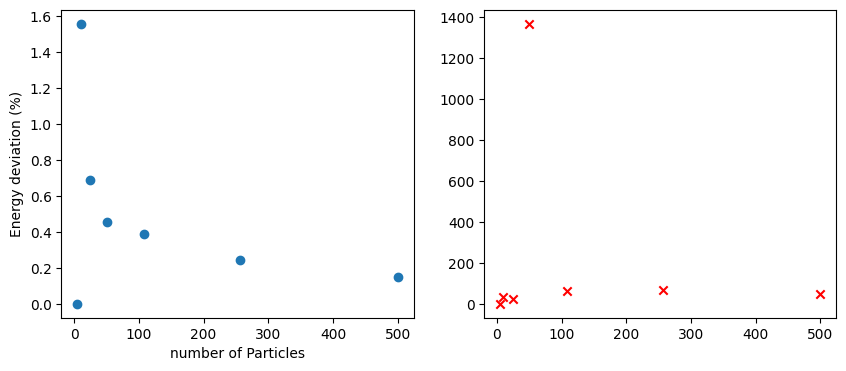

In [6]:
# Calculate the stderrors:

starting_step = 2000
minimalAcceptedBlockSize = 400

energyDeviations = []

pressureDeviations = []

print(f"{'_'*80}")
print(f"{'Energy':^80}")
print(f"{'_'*80}")

print(f"{'n':<10}{f'uncorr standard deviation':<30}{f'correlated stdev':<20}{f'relative Error':}\n")


for i, m in enumerate(particleNumber):
    step, acceptance, energy, pressure = np.loadtxt(f"n{m}/data.dat", unpack = True)

    stepTruncated = step[starting_step:]

    energyTruncated = energy[starting_step:]

    pressureTruncated = pressure[starting_step:]


    ### Energy

    binSize, correlationTime = calculate_correlation_time(energyTruncated)

    averageEnergyCorrelationTime = np.mean(correlationTime[binSize >= minimalAcceptedBlockSize])

    energyMean = np.mean(energyTruncated)

    energyStdev = np.std(energyTruncated, ddof = 1)

    energyCorrStdev = energyStdev * np.sqrt(2 * averageEnergyCorrelationTime / minimalAcceptedBlockSize)

    energyDeviations.append(energyCorrStdev/abs(energyMean)*100)



    # pressure

    binSize, correlationTime = calculate_correlation_time(pressureTruncated)

    averagePressureCorrelationTime = np.mean(correlationTime[binSize >= minimalAcceptedBlockSize])

    pressureMean = np.mean(pressureTruncated)

    pressureStdev = np.std(pressureTruncated, ddof= 1)

    pressureCorrStdev = pressureStdev * np.sqrt(2 * averagePressureCorrelationTime / minimalAcceptedBlockSize)

    pressureDeviations.append(pressureCorrStdev/abs(pressureMean)* 100)

    print(f"{m:<10}{energyStdev:<30.2e}{energyCorrStdev:<20.2e}{energyCorrStdev / energyMean * 100 :>0.2f} %\n")
print(f"{'_'*80}")



#### Plotting it:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

ax1.set_xlabel('number of Particles')
ax1.set_ylabel('Energy deviation (%)')

ax1.scatter(particleNumber, energyDeviations)

ax2.scatter(particleNumber, pressureDeviations, color = 'red', marker = 'x')
#ax2.set_ylim((0,200))
plt.show()

         Coordination number for n = 108:     0.0000
                                   R_min:     0.4050


         Coordination number for n = 256:     0.0000
                                   R_min:     0.3450




         Coordination number for n = 500:     0.0000
                                   R_min:     0.1950




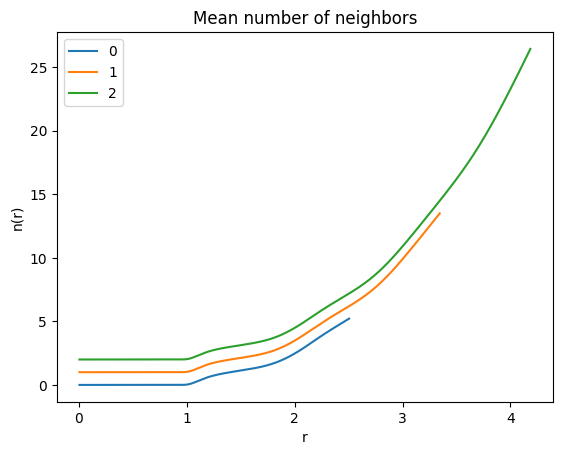

In [7]:
from scipy.signal import argrelmin

nOffset = 1

for i, m in enumerate(particleNumber[4:]):
    r,g = np.loadtxt(f'n{m}/amclj.dat', unpack = True)
    
    integrand = r**2 * g

    n = []
    coordination_number = []
    
    for rj in r:
        n.append(1*np.trapz(integrand[r<=rj], r[r<=rj]))

    index_min = argrelmin(g)[0][0]
    r_min = r[index_min]
    
    n = np.array(n)


    print(f'{f"Coordination number for n = {m}":>40}: {n[r==r_min][0]:>10.4f}\n{f"R_min":>40}: {r_min:>10.4f}\n\n')


    plt.plot(r,n+i*nOffset,label = i)

plt.title('Mean number of neighbors')
plt.xlabel("r")
plt.ylabel("n(r)")
#plt.xlim([1,3.5])
#plt.ylim([0,5])
plt.legend()
plt.show()
        